# Scaling the 2d Acoustic Wave Equation

## Unscaled version

2d Acoustic Wave Equation: $\frac{\partial^2 p}{\partial t^2} = c^2 \nabla^2 p + s(x, z, t)$

Where $ p \equiv p(x, z, t) $ and $ s(x, z, t) $ is a source term

In [47]:
# import dependencies 
from devito import * 
from examples.seismic.source import DGaussSource, TimeAxis
from examples.seismic import RickerSource
from examples.seismic import plot_image

# Initial grid: 2km x 2km, with spacing 100m
extent = (2000., 2000.)
shape = (200, 200)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

# calculating timestep with CFL condition, max V_p=6000, and dx=100
# played around with tn to get different output images - wave hits the edge of the grid around tn=400
t0, tn = 0., 250.
dt = 1e2*(1. / np.sqrt(2.)) / 60.
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# creating source term
src = RickerSource(name='src', grid=grid, f0=0.01, npoint=1, time_range=time_range)
# experimented with both sources
#src = DGaussSource(name='src', grid=grid, f0=0.01, time_range=time_range, a=0.004)
# setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# creating pressure field
p = TimeFunction(name='p', grid=grid, space_order=2, time_order=2)

# choosing a v_p for the purpose of the simulation
V_p = 4.0

# injecting the source term to the pressure field
src_p = src.inject(field=p.forward, expr=src)

# defining pde and creating stencil
pde = p.dt2 - V_p * V_p * p.laplace
stencil = Eq(p.forward, solve(pde, p.forward))

# set up operator
op = Operator([stencil] + src_p)

# call operator to propagate source
op(time=src.time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.003329999999999988, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4.9999999999999996e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

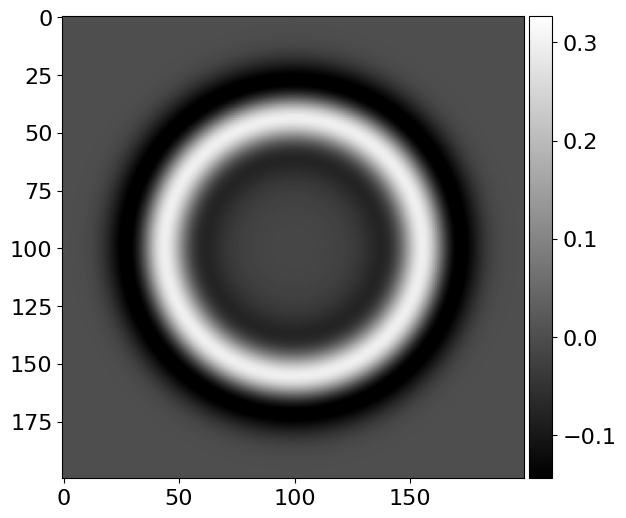

In [48]:
plot_image(p.data[0])